In [2]:
# Importing libraries

import numpy as np
import pandas as pd
import pyexcel
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts
import quandl
import matplotlib.pyplot as plt

In [3]:
# Initializing variables

data = []
headers = ['Date','commodity1','commodity2','zscore','signal','status',\
              'buy price','sell price','mtm','pnl','Cointegration test']
data.append(headers)
threshold = 1.75    # Tolerance for the stdev above and below the mean
start=80
end=90
prev_status = ""
mtm = ""
prev_sell_price = ""
sell_price = ""
prev_buy_price = ""
buy_price = ""
SL = -10000      # Stop loss
TP = 20000       # Take profit
N=5000           # Lot size for data1
M=5000           # Lot size for data2

In [6]:
from quantrautil import get_quantinsti_api_key

# To get your API key, sign up for a free Quandl account.
# Then, you can find your API key on Quandl account settings page.

key = get_quantinsti_api_key()

data1 = quandl.get("CHRIS/MCX_AL1", start_date="2014-04-01", \
                   end_date="2016-07-01", api_key= key)
data2 = quandl.get("CHRIS/MCX_PB1", start_date="2014-04-01", \
                   end_date="2016-07-01", api_key= key)

You need to either pass the API key as parameter to this function (get_quantinsti_api_key(key='<<Your API Key>>') or replace the function call with your API key. To get your API key, sign up for a free Quandl account (https://docs.quandl.com/docs#section-authentication). Then, you can find your API key on Quandl account settings page


In [9]:
QUANDL_API_KEY = 'VpYKj-e3pTXsUxQBMcto'

# Set the start and end date
start_date = '1990-01-01'
end_date = '2018-03-01'

# Set the ticker name
ticker = 'AMZN'

# Feth the data
data1 = quandl.get("CHRIS/MCX_AL1", start_date="2014-04-01", \
                   end_date="2016-07-01", api_key= QUANDL_API_KEY)
data2 = quandl.get("CHRIS/MCX_PB1", start_date="2014-04-01", \
                   end_date="2016-07-01", api_key= QUANDL_API_KEY)


# Print the first 5 rows of the dataframe
data

[['Date',
  'commodity1',
  'commodity2',
  'zscore',
  'signal',
  'status',
  'buy price',
  'sell price',
  'mtm',
  'pnl',
  'Cointegration test']]

In [10]:
# Drop nan columns
data1 = data1.dropna()
data2 = data2.dropna()

# To make the data uniform date wise
data1['key']=data1.index
data2['key']=data2.index

# Merge dataframes to find common dates
result = pd.merge(data1, data2, on='key', left_index=True, right_index=False)

data1 = result[['Open_x','High_x','Low_x','Close_x','Volume_x']] 
data2 = result[['Open_y','High_y','Low_y','Close_y','Volume_y']]

data1.columns = ['Open','High','Low','Close','Volume'] # Rename the columns

data2.columns = ['Open','High','Low','Close','Volume'] # Rename the columns

In [11]:
# Define cointegration test function
def cointegration_test(x, y):
    result = stat.OLS(x['Close'], y['Close']).fit()   # Use OLS method to find the spread of the two series
    return ts.adfuller(result.resid)                  # Check for stationarity of the spread using adfuller test

In [12]:
# Define z-score calculation function
def zscore_cal(data1,data2,start,end):
    s1 = pd.Series(data1['Close'][start:end])
    s2 = pd.Series(data2['Close'][start:end])

    mvavg_old = np.mean(np.log(s1/s2))  # Compute mean of the spread till now

    std_old = np.std(np.log(s1/s2))    #  Compute stdev of the spread till now
    
    current_spread = np.log(data1['Close'][end]/data2['Close'][end])   # Compute spread
    
    # This is the same as current_spread = np.log(data1['Close'][end]) - np.log(data2['Close'][end])
    
    zscore = (current_spread - mvavg_old)/std_old if std_old > 0 else 0  # Compute z-score

    return zscore

In [13]:
# Generating trading signals
def signal_cal(zscore,threshold,adftest):
    if zscore > threshold and adftest == 'Yes': 
        signal = 'SELL' # Z-score is greater than threshold, the spread shall fall towards mean

    elif zscore < -threshold and adftest == 'Yes':
        signal = 'BUY' # Z-score is smaller than threshold, the spread shall rise towards mean
    else:
        signal = ''
    return signal

In [14]:
# Defining status
def status_cal(prev_status,mtm,SL,TP,signal,adftest):
    if prev_status in ["","SL","TP","CB"]:
        status = signal
    else:
        if adftest == "No":
            status = "CB"   # Break in the cointegration status of the pair
        else:
            if mtm == "":
                status = ""
            else:
                if mtm<SL:
                    status="SL"   # Stop loss status
                else:
                    if mtm>TP:
                        status="TP"  # Take profit status
                    else:
                        status = prev_status

    return status

In [15]:
# Calculating buy price
def buy_price_cal(prev_status,prev_buy_price,buy_price,signal,status,data1, data2,end):
    if status == prev_status:
        buy_price = prev_buy_price
    else:
        if status in ["SL","TP","CB",""]:
            buy_price = ""
        else:
            if signal == "BUY":    # Signal is to buy the spread
                buy_price = data1['Close'][end]  # Hence, buy price = close of first security
            else:
                if signal == "SELL":  # Signal is to sell the spread
                    buy_price = data2['Close'][end]  # Hence, buy price = close of second security
                else:
                    buy_price = ""   # no signal hence no buy price

    return buy_price

In [18]:
# Calculating sell price
def sell_price_cal(prev_status,prev_sell_price,sell_price,signal,status, data1,data2,end):
    if status == prev_status:
        sell_price = prev_sell_price
    else:
        if status in ["SL","TP","CB",""]:
            sell_price = ""
        else:
            if signal == "BUY":  # Signal is to buy the spread
                sell_price = data2['Close'][end] # Hence sell price = close of second security
            else:
                if signal == "SELL": # signal is to sell the spread
                    sell_price = data1['Close'][end] # Hence sell price = close of first security
                else:
                    sell_price = "" # No signal hence no sell price either

    return sell_price

In [19]:
# Calculating mtm
def mtm_cal(data1,data2,prev_status,prev_sell_price,prev_buy_price,M,N,end):
    if prev_status == "BUY":
        mtm = (prev_sell_price-data2['Close'][end])*M + (data1['Close'][end]-\
               prev_buy_price)*N  # Calculate mtm of the trades using their lot sizes
    else:
        if prev_status == "SELL":
            mtm =(prev_sell_price-data1['Close'][end])*N +(data2['Close'][end]\
                   -prev_buy_price)*M    # Calculate mtm of the trades using their lot sizes
        else:
            mtm = ""

    return mtm

In [20]:
# Defining the strategy function to execute the pairs trading program
def strategy(data1,data2,threshold,start,end,prev_status,mtm,prev_sell_price,\
             sell_price,prev_buy_price,buy_price,SL,TP,M,N):
    pnl = 0
    i = 0
    for row in data1[90:].iterrows():

         # Running the ADF test for each day, starting from day 91
        d1 = data1[i:90+i]
        d2 = data2[i:90+i]
        c_t = cointegration_test(d1, d2)
        if c_t[0] <= c_t[4]['10%'] and c_t[1] <= 0.1:
            adftest = "Yes"
        else:
            adftest = "No"
   
        # Calculating z-score
        zscore = zscore_cal(data1,data2,start,end)

        # Generating trading signals
        signal = signal_cal(zscore,threshold,adftest)

        # Calculating mtm
        mtm = mtm_cal(data1,data2,prev_status,prev_sell_price,\
                      prev_buy_price,M,N,end)

        # Assigning status
        status = status_cal(prev_status,mtm,SL,TP,signal,adftest)

        # Assigning buy_price
        buy_price = buy_price_cal(prev_status,prev_buy_price,buy_price,\
                                  signal,status,data1,data2,end)


        # Assigning sell_price
        sell_price = sell_price_cal(prev_status,prev_sell_price,sell_price,\
                                    signal,status,data1,data2,end)

        # Calculating pnl
        pnl = (pnl + mtm) if status in ["TP","SL","CB"] else pnl

        # Assigning prev values
        prev_sell_price = sell_price
        prev_status = status
        prev_buy_price = buy_price

        # Appending calculations to the data array
        data.append([str(data1.index[end])[:10],data1['Close'][end],\
                         data2['Close'][end],zscore,signal,status,buy_price,\
                         sell_price,mtm,pnl,adftest])

        # Incrementing variables to consider the next set of data
        end = end+1
        start = start+1
        i = i+1
        
    pyexcel.save_as(array = data, dest_file_name = \
                        'pair_strategy_without_zipline-90.csv')  # Save to CSV for debugging

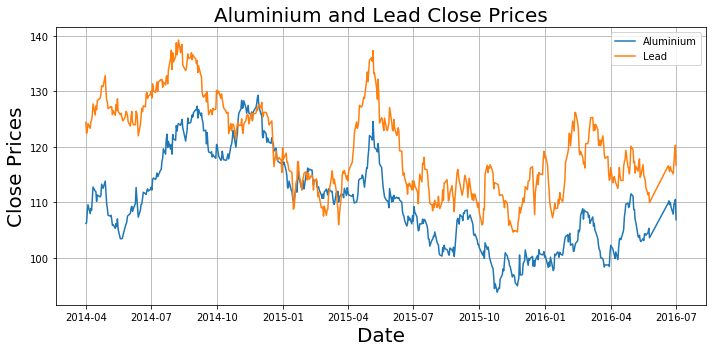

In [21]:
fig,ax = plt.subplots(1,1,figsize = (10,5))

# Plot data1.Close
ax.plot(data1.index, data1.Close, label ='Aluminium') 

# Plot data2.Close
ax.plot(data2.index, data2.Close, label ='Lead') 

plt.legend() # Let matplotlib choose best location for legend
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Close Prices', fontsize = 20)
plt.title('Aluminium and Lead Close Prices', fontsize = 20)

plt.grid() # Display the major grid
plt.tight_layout()
plt.show() # Finally display the plot

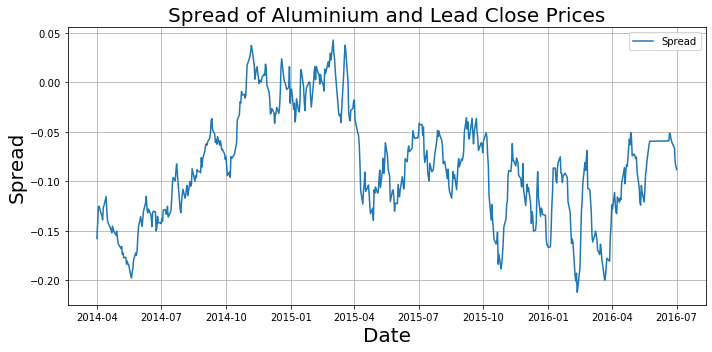

In [22]:
fig,ax = plt.subplots(1,1,figsize = (10,5))

# Plot the spread
ax.plot(data2.index, np.log(data1.Close.values/data2.Close.values), label = 'Spread') 

plt.legend()
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Spread', fontsize = 20)
plt.title('Spread of Aluminium and Lead Close Prices', fontsize = 20)
plt.grid() 
plt.tight_layout()
plt.show() 

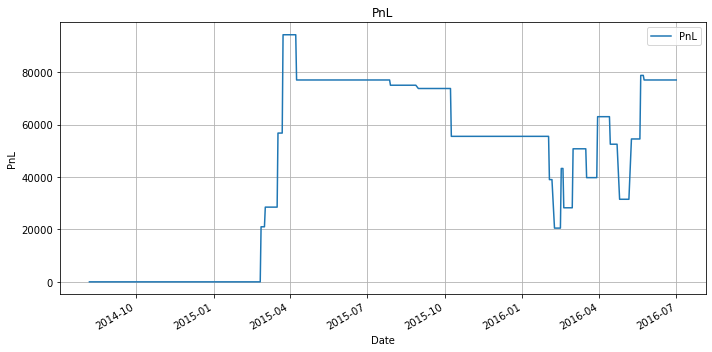

In [23]:
# Run the strategy
strategy(data1,data2,threshold,start,end,prev_status,mtm,prev_sell_price,\
             sell_price,prev_buy_price,buy_price,SL,TP,M,N) 

result = pd.DataFrame(data, columns=headers)[1:] # Ignore the first row
result.set_index('Date',inplace=True)  # Set Date column as index for better plotting
result.index = pd.to_datetime(result.index) # Convert index to a datetime index

result.pnl.plot(figsize=(10,5), label ='PnL') 
plt.legend() 
plt.ylabel('PnL')
plt.title('PnL')
plt.grid() 
plt.tight_layout()
plt.show()